# Piecewise regression modifing class lr (sklearn class)
In this example, the idea is modifiy the class linearRegression to create a group of segmented linear regression

OBS 1: Manually it is necesary to define the threshold to split the data according a certain feature

OBS 2: It could be done creating two object linear regression and train its with differents datasets according the tresholds, but, in some situations it is necesary to have only one artifact that contains the differents models and this codes are very useful in this cases

In [1]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 1. Generate data example

In [2]:
# generate data
# rule: if x <= 0.5 -> y = 70/x

X_train = np.array([[0.2], [0.3], [0.35], [0.7], [0.8], [0.9]]) 
y_train = np.array([350, 233, 200, 50, 100, 200])  

X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)

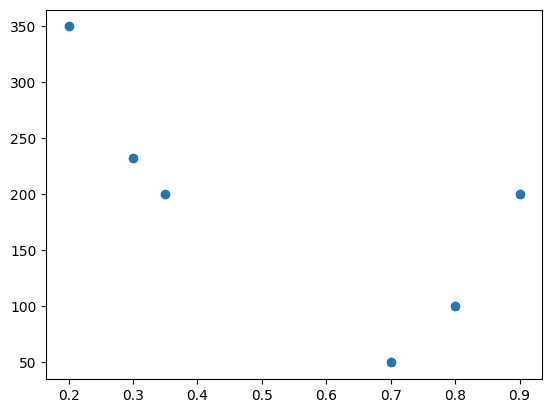

In [3]:
# plot data
plt.scatter(X_train, y_train)

### 2. Train one linear regression

In [4]:
# train
classic_lr = LinearRegression()
classic_lr.fit(X_train, y_train)

# metric
classic_lr.score(X_train, y_train)

0.49512072646797234

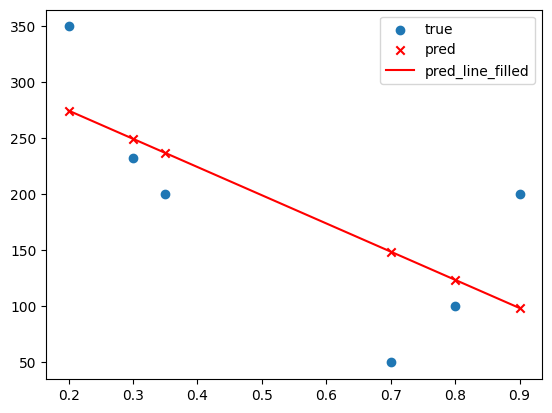

In [5]:
# plot
y_train_pred = classic_lr.predict(X_train)

plt.scatter(X_train, y_train, label = 'true')
plt.scatter(X_train, y_train_pred, label = 'pred', marker = 'x', color = 'red')
plt.plot(X_train, y_train_pred, label = 'pred_line_filled', color = 'red')
plt.legend()

### 3. Train two linear regressions
TWO MODELS

In [6]:
# create models
lr_low_values = LinearRegression()
lr_high_values = LinearRegression()

In [7]:
# define thrshold to divide the data. IN THIS EXAMPLE THE ONLY FEATURE IS X
threshold = 0.5

In [8]:
# divide data train X , y into low and high

# low
X_train_low = X_train[X_train < threshold]
X_train_low.dropna(inplace = True)

y_train_low = y_train.iloc[X_train_low.index, :]


# high
X_train_high = X_train[X_train >= threshold]
X_train_high.dropna(inplace = True)

y_train_high = y_train.iloc[X_train_high.index, :]

In [9]:
X_train_low

,0
0,0.20
1,0.30
2,0.35


In [10]:
X_train_high

,0
3,0.7
4,0.8
5,0.9


In [11]:
# train models
lr_low_values.fit(X_train_low, y_train_low)
lr_high_values.fit(X_train_high, y_train_high)

LinearRegression()

In [12]:
# calculate r2
from sklearn.metrics import r2_score

# calculate y_pred for each model and then concatenate
y_train_pred_low = lr_low_values.predict(X_train_low)
y_train_pred_high = lr_high_values.predict(X_train_high)
y_train_pred = np.array(np.concatenate([y_train_pred_low, y_train_pred_high]))

# r2
r2_score(y_train, y_train_pred)

0.989113781909939

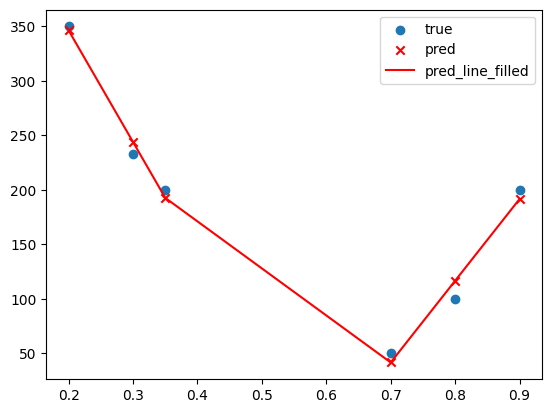

In [13]:
# plot

plt.scatter(X_train, y_train, label = 'true')
plt.scatter(X_train, y_train_pred, label = 'pred', marker = 'x', color = 'red')
plt.plot(X_train, y_train_pred, label = 'pred_line_filled', color = 'red')
plt.legend()

### 4. Train a custom class piecewise-regression. TWO SEGMENTS
This example is create to train only 2 linear regressions according a threshold. IMPORTANT. This could be generalized to train multiple linear regressions

In [14]:
from sklearn.base import BaseEstimator, ClassifierMixin
#class piecewise_regression_2_segments(BaseEstimator, ClassifierMixin):
class piecewise_regression_2_segments(LinearRegression): # this also works
    """
    Class created since sklearn LinearRegression model to inherit all properties of the linear regression class.

    This model train 2 differents lineal regressions splitting the data in two segments.
    This division is defined by one feature and a threshold of this feature. The feature and threshold are defined manually.

    This model can suported multi features but can split the data according only one feature
    """

    def __init__(self, index_column_segment, threshold):

        
        # params to call a instance of this class
        self.index_column_segment = index_column_segment
        self.threshold = threshold
        
        
        # create models
        self.lr_low_values = LinearRegression()
        self.lr_high_values = LinearRegression()



    def transform_df_into_arrays(self, df_or_array):
        """
        Trasform a dataframe into an array. If the input is an array, return it. If the input are other type of data, return an error
        """
        try:
            assert isinstance(df_or_array, (pd.DataFrame, np.ndarray))
            return df_or_array.values if isinstance(df_or_array, pd.DataFrame) else df_or_array
        except AssertionError:
            raise TypeError("A Pandas DataFrame or a NumPy array is expected as input")
    
    
    def split_X_y_according_threshold(self, X, y):
        """
        Split the data X, y according the threshold
    
        Args:
            X (np.array): array with features
            y (np.array): array with target
    
        Return
            X_low (np.array): array with the feature to segment with values lower the threshold
            X_high (np.array): array with the feature to segment with values upper the threshold
            y_low (np.array): array of targets values according the split in the features lower the threshold
            y_high (np.array): array of targets values according the split in the features upper the threshold
        """
        # get idx upper and lower the threshold
        idx_below_threshold = np.where(X[:, self.index_column_segment] <= self.threshold)[0]
        idx_above_threshold = np.where(X[:, self.index_column_segment] > self.threshold)[0]
        
        # get X spplited
        X_low = X[idx_below_threshold]
        X_high = X[idx_above_threshold]
        
        # get y spplited
        y_low = y[idx_below_threshold]
        y_high = y[idx_above_threshold]
    
        return X_low, X_high, y_low, y_high

    
    def split_X_according_threshold(self, X):
        """
        Split the data X, y according the threshold
    
        Args:
            X (np.array): array with features
    
        Return
            X_low (np.array): array with the feature to segment with values lower the threshold
            X_high (np.array): array with the feature to segment with values upper the threshold
            idx_below_threshold (np.array): index data below the threshold. dimensions: (n_below, )
            idx_above_threshold (np.array): index data above the threshold. dimensions: (n_above, )
        """
        
        # get idx upper and lower the threshold
        idx_below_threshold = np.where(X[:, self.index_column_segment] <= self.threshold)[0]
        idx_above_threshold = np.where(X[:, self.index_column_segment] > self.threshold)[0]
        
        # get X spplited
        X_low = X[idx_below_threshold]
        X_high = X[idx_above_threshold]
        
        return X_low, X_high, idx_below_threshold, idx_above_threshold
    
    
    def fit(self, X, y):
        """
        Train the models: lower and upper
        """
        
        # transform into arrays
        X = self.transform_df_into_arrays(X)
        y = self.transform_df_into_arrays(y)
    
        # segmented data according thresholds
        X_low, X_high, y_low, y_high = self.split_X_y_according_threshold(X, y)
    
        # train lower model
        print('debugging: trainning model - low values...')
        self.lr_low_values.fit(X_low, y_low)
    
        # train upper model
        print('debugging: trainning model - high values...')
        self.lr_high_values.fit(X_high, y_high)
    
    
    def predict(self, X):
        """
        Predict with the models: lower and upper
        """
        
        # transform into arrays
        X = self.transform_df_into_arrays(X)
        
        # segmented data according thresholds
        X_low, X_high, idx_below_threshold, idx_above_threshold = self.split_X_according_threshold(X)
        
        # predict lower model
        y_pred_low = self.lr_low_values.predict(X_low)
        
        # predict upper model
        y_pred_high = self.lr_high_values.predict(X_high)
        
        
        # generate only one array y_pred according the indexes
        y_pred = np.zeros((X.shape[0], 1))
        y_pred[idx_below_threshold] = y_pred_low
        y_pred[idx_above_threshold] = y_pred_high
    
        return y_pred

In [15]:
#### example random data

# generate data example
np.random.seed(42)
X_example = np.random.rand(100, 4)
np.random.seed(42)
y_example = np.random.rand(100, 1)


# instance class model segmentation
lr_segments_example = piecewise_regression_2_segments(index_column_segment = 2, 
                                                      threshold = 0.5
                                                     )

# train model
lr_segments_example.fit(X_example, y_example)


# predict
y_pred_example = lr_segments_example.predict(X_example)


# calculate metrics
r2_score(y_example, y_pred_example)

debugging: trainning model - low values...
debugging: trainning model - high values...


0.08955998966310763

In [16]:
type(lr_segments_example)

__main__.piecewise_regression_2_segments

In [17]:
# is the class a lr
isinstance(lr_segments_example, LinearRegression)

True

#### example previosly trained with this class

In [18]:
X_train

,0
0,0.20
1,0.30
2,0.35
3,0.70
4,0.80
5,0.90


In [19]:
y_train

,0
0,350
1,233
2,200
3,50
4,100
5,200


In [20]:
# create model
lr_segments = piecewise_regression_2_segments(index_column_segment = 0,  # in the example, there are only 1 feature
                                              threshold = 0.5 # threshold that works in this shytentic data
                                             )


# fit
lr_segments.fit(X_train, y_train)


# predict
y_train_pred = lr_segments.predict(X_train)

# r2
r2_score(y_train, y_train_pred)

debugging: trainning model - low values...
debugging: trainning model - high values...


0.989113781909939

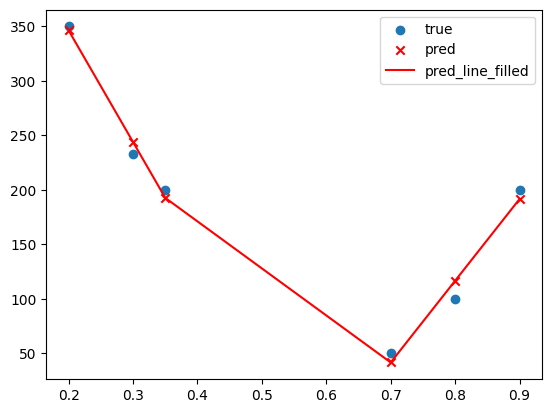

In [21]:
# PLOT
plt.scatter(X_train, y_train, label = 'true')
plt.scatter(X_train, y_train_pred, label = 'pred', marker = 'x', color = 'red')
plt.plot(X_train, y_train_pred, label = 'pred_line_filled', color = 'red')
plt.legend()